## A Deep Learning Method For Solving Fokker-Planck Equations
### Jiayu Zhai, Matthew Dobson, Yao Li
This paper motivates and introduces a neural network for solving the stochastic PDE known as the Fokker-Planck equation. Their model achieves better accuracy at estimating the probability density function (PDF) of the invariant measure compared to a Monte-Carlo approximation, linear projection, and linear approximation methods.

## Motivation: What is an SDE? What is the Fokker-Planck Equation?
Stochastic differential equations (SDEs) are like normal differential equations, except that there is some random noise (i.e., Brownian motion aka Wiener Process). The solutions to SDEs are stochastic processes, not functions like normal DEs. A general SDE (aslo called an Itô process) can be modeled as follows:
$$
dX_t = \mu(X_t, t)dt + \sigma(X_t, t)dW_t
$$
$\mu(X_t, t)dt$ our drift function with respect to time.

$\sigma(X_t, t)dW_t$ is our diffusion function. Note that Wiener processes are not differentiable in the traditional sense. $dW_t$ represents an infitesemially small, random increment of the Wiener process $W_t$ over time.

Drift is the deterministic part of our SDE, and diffusion is stochastic (i.e., randomness proportional to the increment of a Wiener process). Notice that when $\sigma = 0$ our SDE reduces to a deterministic DE.

**The Fokker-Planck Equation**

The Fokker-Planck equation or the Kolmogorov forward equation describes the time evolution of the PDF for a stochastic process. Basically, it describes how our stochastic process changes (shape, spread, shift) over time. It is described as follows
$$
u_t = {L}u = -\sum_{i=1}^n \frac{\partial}{\partial x_i} (f_i u) + \frac{1}{2} \sum_{i,j=1}^n \frac{\partial^2}{\partial x_i \partial x_j} (\Sigma_{i,j} u)
$$
$L$ is the Fokker-Planck operator applied to our PDF $u$.

The first negated summation is our drift term, and the second summation is our diffusion term. $\Sigma = \sigma^T \sigma$ in the diffusion term is our diffusion matrix (also known as the covariance matrix) where $ \sigma$ is the diffusion coefficient matrix from the SDE.

Like many DEs, SDEs are usually very hard or impossible to solve analytically. Many numerical approximators exist, such as one described below.

## Solver 1: Monte-Carlo simulation and the Euler-Maruyama Approximation
I promise I'm not trying to spew a bunch of keywords!
The idea of Monte-Carlo simulation is we take a bunch of random trajectories of our SDE and treat those as samples from its invariant (stationary) distribution. We then estimate the density of this distribution.

In the world of traditional DEs, we have numerical approximations like the Euler method that define an iterative formula to find "steps" representing the slope of our function at a point in time, but how do we do this if we don't know where we're going (a familiar problem of late adolescene and early adulthood I can assure you)?

In the world of SDEs, a well-known numerical estimator for generating such an iterative formula is known as the Euler-Maruyama method:
$$
X_{n+1} = X_n + f(X_n)\Delta t + \sigma(X_n)\sqrt{\Delta t}\,Z_n
$$
Where $Z_n \sim N(0,I_d)$, $\sigma(X_n) \in R^{d \times d}$

$X_{n}$ is the step in our stochastic process, $f(X_n)\Delta{t}$ is our drift term and $\sigma(X_n)\sqrt{\Delta t}Z_n$ is our diffusion term.

We now have a way to define paths, and an idea about collecting states from said paths to estimate the PDF of our equation!

In [4]:
# Solver 1: Monte-Carlo simulation with Euler-Maruyama Approximation

import jax.numpy as jnp
from jax import random

# Drift functions
def drift_f_1(x, y):
  return (-4 * x) * (x**2 + y**2 - 1) + y

def drift_f_2(x, y):
  return (-4 * y) * (x**2 + y**2 - 1) - x

def drift(state):
  x, y = state
  return jnp.array([drift_f_1(x, y), drift_f_2(x, y)])

# Diffusion noise
# sigma = 1, so our covariance matrix is simply I_2
def diffusion_noise(key, dt):
  # returns sqrt(dt) * Z_n  where Z_n ~ N(0, I_2)
  z = random.normal(key, shape=(2,))
  return jnp.sqrt(dt) * z

# Euler-Maruyama Step
def em_step(state, key, dt):
  drift_val = drift(state)
  noise = diffusion_noise(key, dt)
  return state + drift_val * dt + noise

In [5]:
# Trajectory simulation
from jax import lax

def simulate_trajectory(key, x0, dt, n_steps):
  keys = random.split(key, n_steps)

  def body(state, k):
    state_next = em_step(state, k, dt)
    return state_next, state_next

  states = lax.scan(body, x0, keys)[1]  # states: (n_steps, 2)
  return states

# Burn-in and thinning
def burn_and_thin(states, burn_steps, thin):
  states = states[burn_steps:]
  return states[::thin]

In [6]:
# Histogram density
def hist2d_density(samples, xlim=(-2,2), ylim=(-2,2), bins=200):
  x = samples[:, 0]
  y = samples[:, 1]
  Nx = Ny = bins

  # Map to bin indices
  i = jnp.floor((x - xlim[0]) / (xlim[1] - xlim[0]) * Nx).astype(jnp.int32)
  j = jnp.floor((y - ylim[0]) / (ylim[1] - ylim[0]) * Ny).astype(jnp.int32)

  mask = (i >= 0) & (i < Nx) & (j >= 0) & (j < Ny)
  i, j = i[mask], j[mask]

  idx = i * Ny + j
  counts = jnp.bincount(idx, length=Nx*Ny).reshape((Nx, Ny))

  dx = (xlim[1]-xlim[0]) / Nx
  dy = (ylim[1]-ylim[0]) / Ny
  density = counts / (counts.sum() * dx * dy)

  x_centers = jnp.linspace(xlim[0], xlim[1], bins, endpoint=False) + dx/2
  y_centers = jnp.linspace(ylim[0], ylim[1], bins, endpoint=False) + dy/2
  return density, x_centers, y_centers


In [7]:
# Simulation Parameters
key = random.PRNGKey(0)

dt = 1e-3
n_steps = 10_000_000     # 1e7 for smoother density estimate
burn_steps = 50_000
thin = 10                # keeps ~ (n_steps-burn)/thin samples
x0 = jnp.array([0.0, 0.0])

states = simulate_trajectory(key, x0, dt, n_steps)
samples = burn_and_thin(states, burn_steps, thin)

density, xc, yc = hist2d_density(samples, xlim=(-2,2), ylim=(-2,2), bins=100)

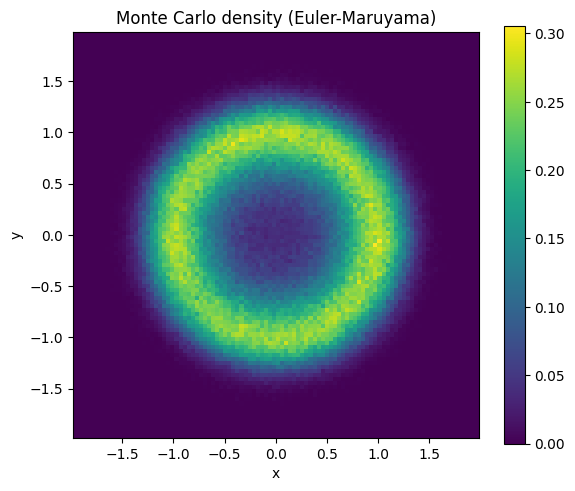

In [8]:
# Plot the density

import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.imshow(
    jnp.array(density).T,
    origin="lower",
    extent=[xc[0], xc[-1], yc[0], yc[-1]],
    aspect="equal",
)
plt.colorbar()
plt.title("Monte Carlo density (Euler-Maruyama)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


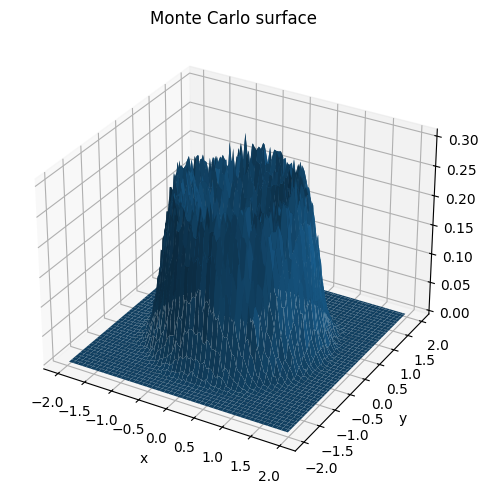

In [9]:
# 3D Surface approximation

X, Y = jnp.meshgrid(xc, yc, indexing="ij")
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(jnp.array(X), jnp.array(Y), jnp.array(density), rstride=2, cstride=2, linewidth=0)
ax.set_title("Monte Carlo surface")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tight_layout()
plt.show()

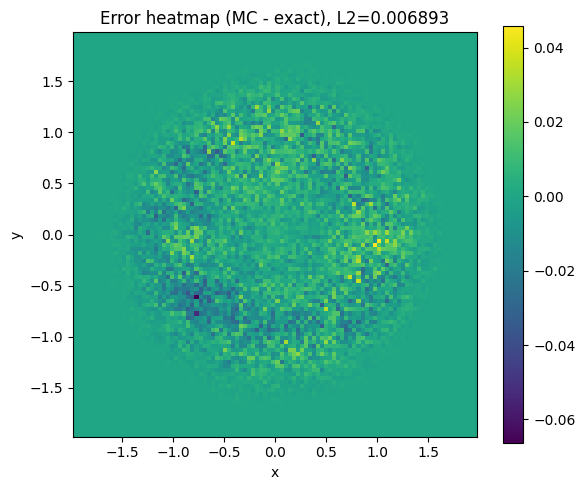

In [10]:
# Visualizing the error

def exact_ring_density(x, y, sigma=1.0):
    V = (x**2 + y**2 - 1.0)**2
    return jnp.exp(-2.0 * V / (sigma**2))

# Evaluate exact on grid centers and normalize on the box for comparison
Xg, Yg = jnp.meshgrid(xc, yc, indexing="ij")
u_unnorm = exact_ring_density(Xg, Yg, sigma=1.0)

dx = (xc[-1]-xc[0])/(len(xc)-1)  # approximate spacing
dy = (yc[-1]-yc[0])/(len(yc)-1)
u_exact = u_unnorm / (u_unnorm.sum() * dx * dy)

err = density - u_exact
l2 = jnp.sqrt(jnp.mean(err**2))

plt.figure(figsize=(6,5))
plt.imshow(
    jnp.array(err).T,
    origin="lower",
    extent=[xc[0], xc[-1], yc[0], yc[-1]],
    aspect="equal",
)
plt.colorbar()
plt.title(f"Error heatmap (MC - exact), L2={float(l2):.6f}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# Solver 2: A Neural-Network Approach